Airline AI Assistant
- We will now bring together what we have learned to make an AI Customer Support Assistant for an Airline

In [1]:
import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [2]:
load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

openai = OpenAI()
MODEL = 'gpt-4o-mini'

In [3]:
system_message = "You are a helpful assistant for an Airline called FlightAI."
system_message += "Give short, courteous answers, no more than 1 sentence."
system_message += "Always be accurate. If you don't know the answer, say No."

In [4]:
def chat(message, history):
    messages = [{"role" : "system", "content" : system_message}]
    for human, assistant in history:
        messages.append({"role":"user", "content":human})
        messages.append({"role": "assistant", "content": assistant})
    messages.append({"role": "user", "content": message})

    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat).launch()

c:\Users\KajalMore\VSCODE\self_learning\env\Lib\site-packages\gradio\components\chatbot.py:288: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


The Function Calling Tool

In [5]:
ticket_prices = {"pune": "5000", "vizaq": "4000", "mumbai": "3800", "aurangabad":"8000", "shirdi":"7000"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [6]:
get_ticket_price("Pune")

Tool get_ticket_price called for Pune


'5000'

In [7]:
# There is a particular dictionary structure that's required to describe our function

price_function = {
    "name" : "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [8]:
# And this is included in a list of tools:

tools = [{"type":"function", "function":price_function}]

Getting OpenAI to use our Tool

In [9]:
def chat(message, history):
    messages = [{"role" : "system", "content" : system_message}]
    for human, assistant in history:
        messages.append({"role":"user", "content":human})
        messages.append({"role": "assistant", "content": assistant})
    messages.append({"role": "user", "content": message})

    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    
    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)

        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

In [10]:
# We have to write that function handle_tool_call

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role" : "tool",
        "content" : json.dumps({"destination_city": city, "price":price}),
        "tool_call_id": message.tool_calls[0].id
    }

    return response, city

In [12]:
gr.ChatInterface(fn=chat).launch()

c:\Users\KajalMore\VSCODE\self_learning\env\Lib\site-packages\gradio\components\chatbot.py:288: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


Let's Go Multi-modal
- We can use DALL-E-3, the image generation model behind the GPT-4o, to make us some images

In [13]:
import base64
from io import BytesIO
from PIL import Image

In [14]:
def artist(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

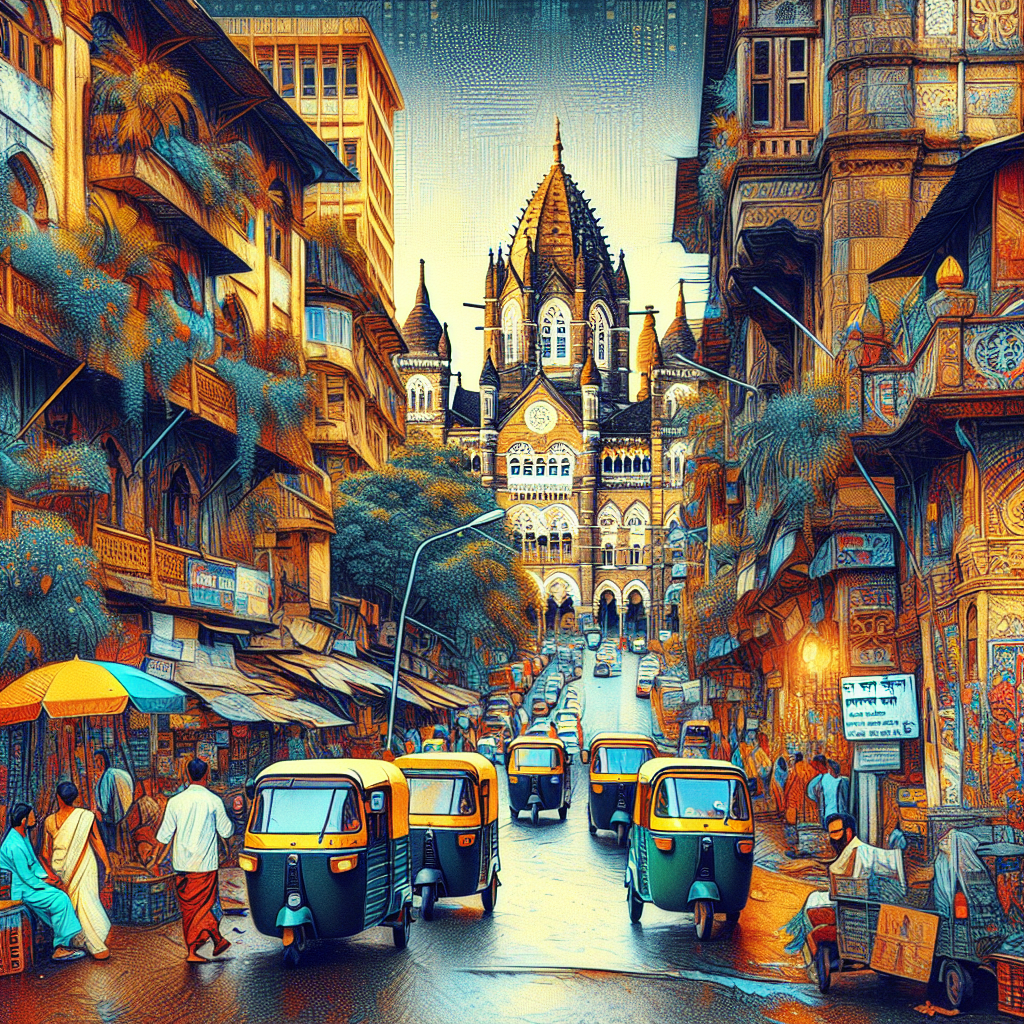

In [15]:
image = artist("Mumbai City")
display(image)

#### Audio
- Lets make a function talker that uses OpenAIs speech model to generate audio

In [16]:
from pydub import AudioSegment
from pydub.playback import play

def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice = "onyx",
        input=message
    )

    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

In [ ]:
talker("Hi there!")